***Importing Libraries***

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from google.colab import drive
drive.mount('/content/drive')

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer, recall_score, f1_score, cohen_kappa_score
from sklearn.preprocessing import OneHotEncoder

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Uploading Data v1.0 - Random Forest 1

In [ ]:
path = '/content/drive/Shareddrives/Data_TFM/Dataset_Final/df_final_v6.csv'

df = pd.read_csv(path, sep=",", low_memory=False)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3201849 entries, 0 to 3201848
Data columns (total 38 columns):
 #   Column                                                      Dtype  
---  ------                                                      -----  
 0   date_day                                                    object 
 1   unique_venue_id                                             int64  
 2   antiguedad                                                  float64
 3   saas_product_tw_connect                                     float64
 4   saas_product_tw_pro                                         float64
 5   n_channel                                                   float64
 6   net_orders                                                  float64
 7   orders_cancellation_rate                                    float64
 8   net_aov                                                     float64
 9   net_take_rate                                               float64
 10  prepay

## Creating and training the model v1.0

In [ ]:
# Creating train / test datasets
X_train = df[df["date_day"] <= "2022-12-31"].drop(["churn"], axis=1)
X_test = df[(df["date_day"] > "2022-12-31") & (df["date_day"] < "2023-06-01")].drop(["churn"], axis=1)
y_train = df[df["date_day"] <= "2022-12-31"][["unique_venue_id", "date_day","churn"]]
y_test = df[(df["date_day"] > "2022-12-31") & (df["date_day"] < "2023-06-01")][["unique_venue_id", "date_day","churn"]]

# Creating Indexs
X_train = X_train.set_index(['date_day', 'unique_venue_id'])
X_test = X_test.set_index(['date_day', 'unique_venue_id'])
y_train = y_train.set_index(['date_day', 'unique_venue_id'])
y_test = y_test.set_index(['date_day', 'unique_venue_id'])

- We have created the variable "month" to add it to the model since we observed seasonality in the EDA.
- We have created the train and test sets using "date_day" to segment the sets based on the date due to seasonality.
    - **Train**: The train set contains all data from 2021 and 2022.
    - **Test**: The test set contains all data from January 2023 to May 2023.
    - **Validation**: The validation set will start from June 2023.
- We have created the indices "date_day" and "unique_venue_id" to keep the sets ordered.

In [ ]:
# Creating Random Forest instance
random_forest_clf = RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=3, min_samples_leaf=1)

# Training the model
model_churn_random_forest = random_forest_clf.fit(X_train, y_train)

# Obtaining Churn/NotChurn Probabilities and mantaining indexes 
probs_train = pd.DataFrame(model_churn_random_forest.predict_proba(X_train), index=X_train.index)
probs_test = pd.DataFrame(model_churn_random_forest.predict_proba(X_test), index=X_test.index)

# Obtaining predictions and mantaining indexes 
preds_train = pd.DataFrame(model_churn_random_forest.predict(X_train), index=X_train.index)
preds_test = pd.DataFrame(model_churn_random_forest.predict(X_test), index=X_test.index)

# Obtaining predictions to create confusion matrix and classification report 
prediction_churn_random_forest=model_churn_random_forest.predict(X_test)

<ipython-input-23-40b4c1a80bff>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_churn_random_forest = random_forest_clf.fit(X_train, y_train)


- We have created 2 different dataframes for both the train and test sets:
    - **probs**: Contains the probabilities that the record is churn (0-1).
    - **preds**: Contains the prediction that the record is churn.

In [ ]:
import pickle
# Recall
# Saving the model in .pkl format 
path = '/content/drive/Shareddrives/Data_TFM/Notebooks/rf_benchmark.pkl'
with open(path, 'wb') as f:
    pickle.dump(random_forest_clf, f)

## Searchgrid: RECALL vs F-1/KAPPA 

In [ ]:
# Definir los hiperparámetros a ajustar
param_grid = {
    'n_estimators': [3, 6, 9, 50, 100],
    'max_depth': [2, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}

# Define custom scorers
scorers = {
    'recall': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score),
    'kappa': make_scorer(cohen_kappa_score)
}

# Perform grid search for each metric
best_models = {}
execution_times = {}

for metric in scorers:
    start_time = time.time()  # Registrar el tiempo de inicio
    grid_search = GridSearchCV(estimator=model_churn_random_forest, param_grid=param_grid, cv=3, scoring=scorers[metric], refit=metric)
    # grid_search.fit(X_train, y_train)
    # /usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
    # estimator.fit(X_train, y_train, **fit_params)
    grid_search.fit(X_train, y_train['churn'].values.ravel())
    end_time = time.time()  # Registrar el tiempo de finalización

    execution_time = end_time - start_time
    execution_times[metric] = execution_time

    best_models[metric] = {
        'best_params': grid_search.best_params_,
        'best_model': grid_search.best_estimator_
    }

# Imprimir los resultados
for metric in best_models:
    print(f"Mejores parámetros encontrados para {metric}: {best_models[metric]['best_params']}")
    print(f"Mejor modelo encontrado para {metric}: {best_models[metric]['best_model']}")
    print(f"Tiempo de ejecución para {metric}: {execution_times[metric]} segundos\n")

**Summary:**

**Recall:**
* Best parameters found for recall: `{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 3}`
* Best model found for recall: `RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=3)`
* Execution time for recall: `12296.452771663666` seconds

**F1-Score:**
* Best parameters found for f1_score: `{'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 50}`
* Best model found for f1_score: `RandomForestClassifier(max_depth=5, min_samples_leaf=5, n_estimators=50)`
* Execution time for f1_score: `11874.724573373795` seconds

**Kappa:**
* Best parameters found for kappa: `{'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 6}`
* Best model found for kappa: `RandomForestClassifier(max_depth=5, min_samples_leaf=10, n_estimators=6)`
* Execution time for kappa: `11748.037635564804` seconds

## Improved models

**Recall**

In [ ]:
# Recall

start_time = time.time()  # Record the start time

# Create the Random Forest instance
rf_recall = RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=3, min_samples_leaf=1)

# Train the model
rf_recall.fit(X_train, y_train)

# Get class probabilities and keep the indices
probs_train_rf_recall = pd.DataFrame(rf_recall.predict_proba(X_train), index=X_train.index)
probs_test_rf_recall = pd.DataFrame(rf_recall.predict_proba(X_test), index=X_test.index)

# Get predictions and keep the indices
preds_train_rf_recall = pd.DataFrame(rf_recall.predict(X_train), index=X_train.index)
preds_test_rf_recall = pd.DataFrame(rf_recall.predict(X_test), index=X_test.index)

# Get predictions to create the confusion matrix and classification report
prediction_rf_recall = rf_recall.predict(X_test)

end_time = time.time()  # Record the end time

# Model Training Time
execution_time = end_time - start_time
print(execution_time, "seconds or", execution_time/60, "minutes")

<ipython-input-11-dcce6d53ed3c>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_recall.fit(X_train, y_train)


21.514073610305786 segundos o  0.35856789350509644 minutos


**F-1 Score**

In [ ]:
# F1-Score

start_time = time.time()  # Record the start time

# Create the Random Forest instance
rf_f1 = RandomForestClassifier(max_depth=5, min_samples_split=2, n_estimators=50, min_samples_leaf=10)

# Train the model
rf_f1.fit(X_train, y_train)

# Get class probabilities and keep the indices
probs_train_rf_f1 = pd.DataFrame(rf_f1.predict_proba(X_train), index=X_train.index)
probs_test_rf_f1 = pd.DataFrame(rf_f1.predict_proba(X_test), index=X_test.index)

# Get predictions and keep the indices
preds_train_rf_f1 = pd.DataFrame(rf_f1.predict(X_train), index=X_train.index)
preds_test_rf_f1 = pd.DataFrame(rf_f1.predict(X_test), index=X_test.index)

# Get predictions to create the confusion matrix and classification report
prediction_rf_f1 = rf_f1.predict(X_test)

end_time = time.time()  # Record the end time

# Model Training Time
execution_time = end_time - start_time
print(execution_time, "seconds or", execution_time/60, "minutes")


<ipython-input-12-aecbdb7f91e3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_f1.fit(X_train, y_train)


102.25054407119751 segundos o  1.7041757345199584 minutos


**Kappa**

In [ ]:
# Kappa

start_time = time.time()  # Record the start time

# Create the Random Forest instance
rf_kappa = RandomForestClassifier(max_depth=5, min_samples_split=2, n_estimators=6, min_samples_leaf=10)

# Train the model
rf_kappa.fit(X_train, y_train)

# Get class probabilities and keep the indices
probs_train_rf_kappa = pd.DataFrame(rf_kappa.predict_proba(X_train), index=X_train.index)
probs_test_rf_kappa = pd.DataFrame(rf_kappa.predict_proba(X_test), index=X_test.index)

# Get predictions and keep the indices
preds_train_rf_kappa = pd.DataFrame(rf_kappa.predict(X_train), index=X_train.index)
preds_test_rf_kappa = pd.DataFrame(rf_kappa.predict(X_test), index=X_test.index)

# Get predictions to create the confusion matrix and classification report
prediction_rf_kappa = rf_kappa.predict(X_test)

end_time = time.time()  # Record the end time

# Model Training Time
execution_time = end_time - start_time
print(execution_time, "seconds or", execution_time/60, "minutes")


<ipython-input-13-659aad4d57da>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_kappa.fit(X_train, y_train)


13.951596736907959 segundos o  0.23252661228179933 minutos


## Saving Models 

In [ ]:
import pickle

# Recall
# Save the model to a file with .pkl extension
path_recall = '/content/drive/Shareddrives/Data_TFM/Notebooks/rf_recall.pkl'
with open(path_recall, 'wb') as f:
    pickle.dump(rf_recall, f)

# F1-Score
# Save the model to a file with .pkl extension
path_f1 = '/content/drive/Shareddrives/Data_TFM/Notebooks/rf_f1.pkl'
with open(path_f1, 'wb') as f:
    pickle.dump(rf_f1, f)

# Kappa
# Save the model to a file with .pkl extension
path_kappa = '/content/drive/Shareddrives/Data_TFM/Notebooks/rf_kappa.pkl'
with open(path_kappa, 'wb') as f:
    pickle.dump(rf_kappa, f)

**Uploading Model**

In [ ]:
# Full path of the file where you saved the model
#path = '/content/drive/Shareddrives/Data_TFM/Notebooks/model_churn.pkl'

# Load the model from the .pkl file
#with open(path, 'rb') as f:
#    model_churn_random_forest = pickle.load(f)

## Evaluate the model (custom metric)

We are going to create a custom metric called "Accuracy_top_prob" which will measure the percentage of correct predictions we have obtained on the records with a churn probability of 100%. We will apply this metric to both the training and test sets.

In [ ]:
# Merge dataframes
df_train = pd.concat([probs_train, preds_train, y_train], axis=1)
df_train = df_train.set_axis(["prob_0", "prob_1", "pred", "churn"], axis=1)

print("The number of rows in the train set with a churn probability of 100% is:", len(df_train[df_train["prob_1"] == 1]))
print("The percentage of rows in the train set with a churn probability of 100% is:", len(df_train[df_train["prob_1"] == 1])/len(df_train))
print("The number of rows in the train set with a churn probability of 0% is:", len(df_train[df_train["prob_1"] == 0]))
print("The percentage of rows in the train set with a churn probability of 0% is:", len(df_train[df_train["prob_1"] == 0])/len(df_train))

df_train

La cantidad de rows del conjunto train con una probabilidad de churn del 100% es: 0
El porcentaje de rows del conjunto train con una probabilidad de churn del 100% es: 0.0
La cantidad de rows del conjunto train con una probabilidad de churn del 0% es: 0
El porcentaje de rows del conjunto train con una probabilidad de churn del 0% es: 0.0


prob_0    prob_1  pred  churn
date_day   unique_venue_id                                 
2021-06-01 11000000002      0.137861  0.862139   1.0    1.0
           11000000004      0.849555  0.150445   0.0    0.0
           11000000006      0.849555  0.150445   0.0    0.0
           11000000007      0.849555  0.150445   0.0    0.0
           11000000008      0.849555  0.150445   0.0    0.0
...                              ...       ...   ...    ...
2022-12-01 13026415610      0.208440  0.791560   1.0    1.0
           13026415939      0.102262  0.897738   1.0    1.0
           13026416171      0.994768  0.005232   0.0    0.0
           13026416368      0.996568  0.003432   0.0    0.0
           13026416403      0.208440  0.791560   1.0    1.0

[2451967 rows x 4 columns]

In [ ]:
# Unify the DataFrames
df_test = pd.concat([probs_test, preds_test, y_test], axis=1)
df_test = df_test.set_axis(["prob_0", "prob_1", "pred", "churn"], axis=1)

print("The number of rows in the test set with a churn probability of 100% is:", len(df_test[df_test["prob_1"] == 1]))
print("The percentage of rows in the test set with a churn probability of 100% is:", len(df_test[df_test["prob_1"] == 1])/len(df_test))
print("The number of rows in the test set with a churn probability of 0% is:", len(df_test[df_test["prob_1"] == 0]))
print("The percentage of rows in the test set with a churn probability of 0% is:", len(df_test[df_test["prob_1"] == 0])/len(df_test))

df_test

La cantidad de rows del conjunto test con una probabilidad de churn del 100% es: 0
El porcentaje de rows del conjunto test con una probabilidad de churn del 100% es: 0.0
La cantidad de rows del conjunto test con una probabilidad de churn del 0% es: 0
El porcentaje de rows del conjunto test con una probabilidad de churn del 0% es: 0.0


prob_0    prob_1  pred  churn
date_day   unique_venue_id                                 
2023-01-01 11000000002      0.137861  0.862139   1.0    1.0
           11000000003      0.137861  0.862139   1.0    1.0
           11000000004      0.849555  0.150445   0.0    0.0
           11000000005      0.102262  0.897738   1.0    1.0
           11000000006      0.849555  0.150445   0.0    0.0
...                              ...       ...   ...    ...
2023-05-01 12000048321      0.579090  0.420910   0.0    0.0
           12000048322      0.579090  0.420910   0.0    0.0
           12000048323      0.579090  0.420910   0.0    0.0
           12000048324      0.579090  0.420910   0.0    0.0
           12000048325      0.579090  0.420910   0.0    0.0

[749882 rows x 4 columns]

In [ ]:
df_top_predictions_train = df_train.sort_values(by=["prob_1"], ascending=False).head(100)
df_top_predictions_train["correct"] = (df_top_predictions_train["pred"] == df_top_predictions_train["churn"]).astype(float)
accuracy_top_prob_train = df_top_predictions_train["correct"].sum()/100
accuracy_top_prob_train

1.0

In [ ]:
df_top_predictions_test = df_test.sort_values(by=["prob_1"], ascending=False).head(100)
df_top_predictions_test["correct"] = (df_top_predictions_test["pred"] == df_top_predictions_test["churn"]).astype(float)
accuracy_top_prob_test = df_top_predictions_test["correct"].sum()/100
accuracy_top_prob_test

0.98

As can be observed, the training set has shown better performance than the test set. This is expected, as the model has been trained on the training set data and is more familiar with it.

## Evaluating model performance (Confusion Matrix)

[Text(0, 0, 'Not Churn'), Text(0, 1, 'Churn')]

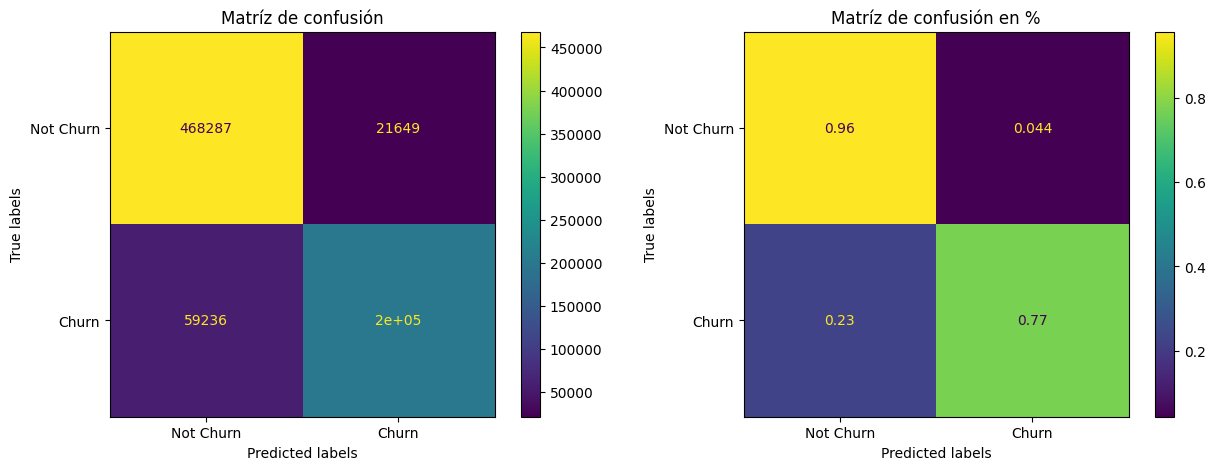

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Confusion Matrix
cm = confusion_matrix(y_test, prediction_churn_random_forest)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=ax1)
ax1.set_title("Matríz de confusión")
ax1.set_xlabel('Predicted labels')
ax1.set_ylabel('True labels')
ax1.set_xticklabels(['Not Churn', 'Churn'])
ax1.set_yticklabels(['Not Churn', 'Churn'])

# Confusion Matrix % 
cm_percent = cm / cm.sum(axis=1, keepdims=True)
ConfusionMatrixDisplay(confusion_matrix=cm_percent).plot(ax=ax2)
ax2.set_title("Matríz de confusión en %")
ax2.set_xlabel('Predicted labels')
ax2.set_ylabel('True labels')
ax2.set_xticklabels(['Not Churn', 'Churn'])
ax2.set_yticklabels(['Not Churn', 'Churn'])

In [ ]:
print(classification_report(y_test, prediction_churn_random_forest))

              precision    recall  f1-score   support

         0.0       0.89      0.96      0.92    489936
         1.0       0.90      0.77      0.83    259946

    accuracy                           0.89    749882
   macro avg       0.90      0.86      0.88    749882
weighted avg       0.89      0.89      0.89    749882



The accuracy is high for both classes. This indicates that the model has good ability to correctly predict positive and negative cases in both classes. However, the recall is slightly lower for class "1", suggesting that the model may have more difficulty identifying churn cases correctly.

In summary, although the model shows good results in terms of accuracy and recall for both classes, it is important to consider that recall for the minority class may be more relevant in an imbalanced churn problem.

Finally, it's worth mentioning that we will attempt to find the best hyperparameters based on improving recall.

## Feature Importance

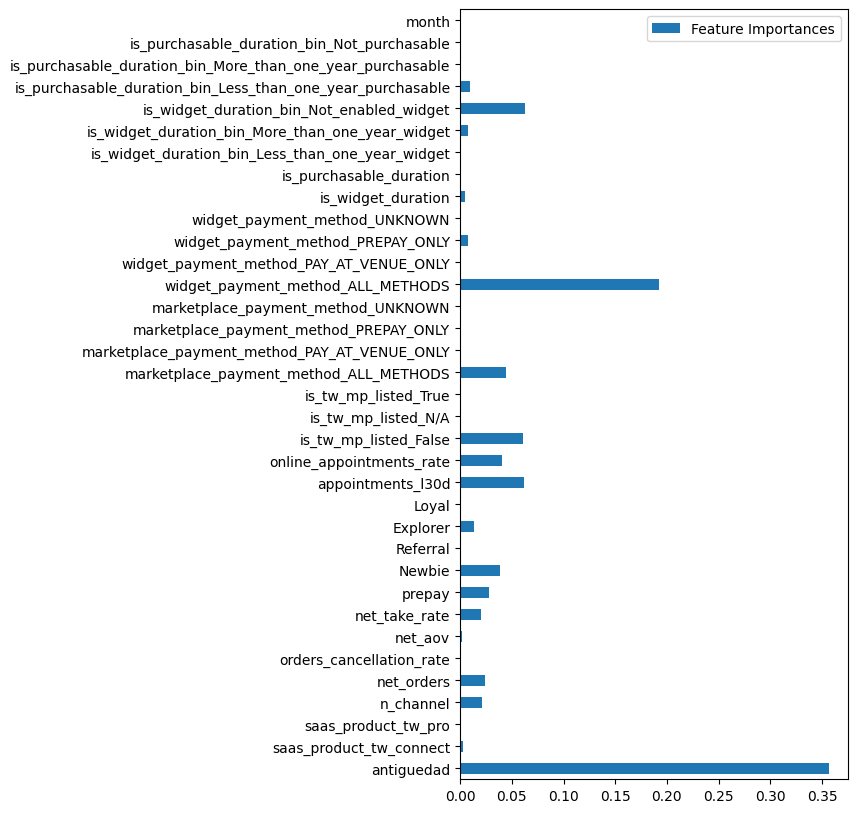

In [ ]:
df_imp = pd.DataFrame(model_churn_random_forest.feature_importances_.reshape(1,-1), columns=X_train.columns, index=["Feature Importances"])
df_imp.T.plot.barh(figsize=(5, 10))
plt.legend()
# Save the figure
plt.savefig('feature_importances.png')

<Figure size 1000x800 with 0 Axes>

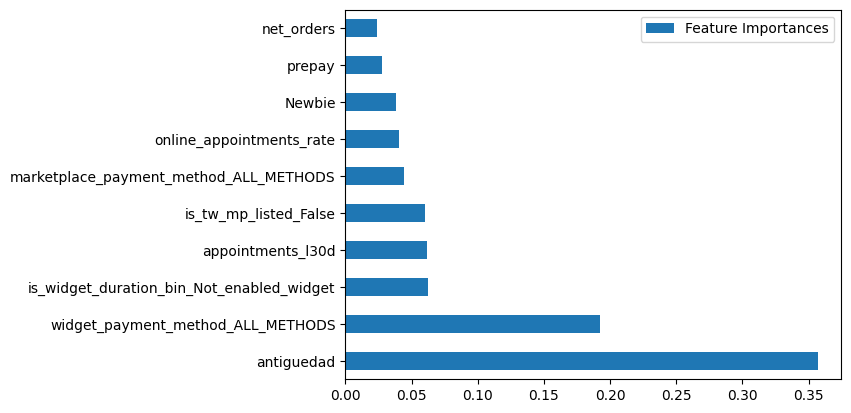

In [ ]:
# Transpose the DataFrame and select the top 10 important features
top_10_imp = df_imp.T.nlargest(10, "Feature Importances")

# Plot the top 10 important features
plt.figure(figsize=(10, 8))
top_10_imp.plot.barh()
plt.legend()

# Show the plot
plt.show()

In [ ]:
#from google.colab import files
# Download the image
#files.download('feature_importances.png')

Variablws with most importance for this model are:

- Antiguedad
- Is_widget_duration_bin_not_enabled
- Appointments_l30d
- Loyal
- Widget_payment_method_all_methods

<Figure size 1000x800 with 0 Axes>

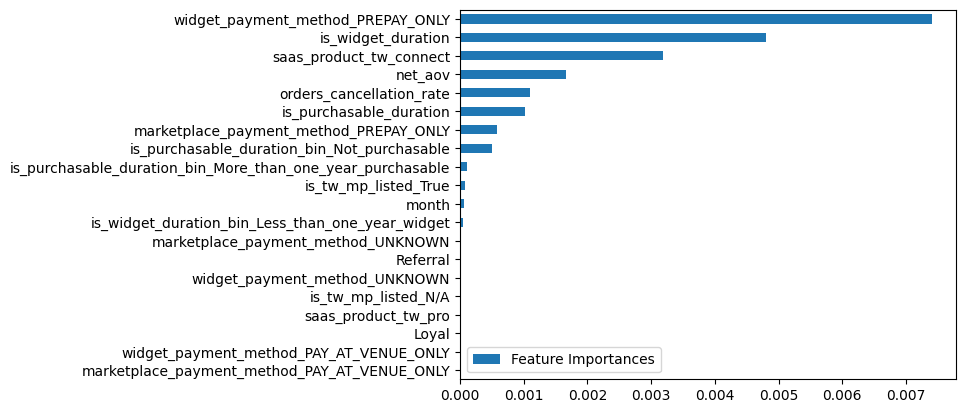

In [ ]:
# Select the 20 least important features
bottom_20_imp = df_imp.T.nsmallest(20, "Feature Importances")

# Plot the 20 least important features
plt.figure(figsize=(10, 8))
bottom_20_imp.plot.barh()
plt.legend()

# Show the plot
plt.show()

###



In [ ]:
pip install scikit-plot

**Importing models**

In [ ]:
import pickle

# Full path to the file where you saved the recall model
path_recall = '/content/drive/Shareddrives/Data_TFM/Notebooks/rf_recall.pkl'

# Load the model from the .pkl file
with open(path_recall, 'rb') as f:
    rf_recall = pickle.load(f)

# Full path to the file where you saved the F1 model
path_f1 = '/content/drive/Shareddrives/Data_TFM/Notebooks/rf_f1.pkl'

# Load the model from the .pkl file
with open(path_f1, 'rb') as f:
    rf_f1 = pickle.load(f)

# Full path to the file where you saved the Kappa model
path_k = '/content/drive/Shareddrives/Data_TFM/Notebooks/rf_kappa.pkl'

# Load the model from the .pkl file
with open(path_k, 'rb') as f:
    rf_kappa = pickle.load(f)

In [ ]:
import pickle

# Full path to the file where you saved the model
path_rf_benchmark = '/content/drive/Shareddrives/Data_TFM/Notebooks/rf_benchmark.pkl'

# Load the model from the .pkl file
with open(path_rf_benchmark, 'rb') as f:
    rf_benchmark = pickle.load(f)

## Lift Formula

In [ ]:
def calc_lift(y_test, probs_test, bins=10):
    """
    Calculate the lift given true labels and prediction. Note this only works for a binary classifier.
    Parameters
    -------------------
    y:    a 1-d Numpy array or Pandas Series of the true label
    y_prob: predicted probablity of positive class
    bins: number of equal sized quantiles to divide observations across (default is 10).
    """

    df = pd.DataFrame({'actual': y_test, 'pred_prob': probs_test})

    n_positives = df['actual'].sum()
    n_obs = df.shape[0]
    # baseline with a random classifier
    baseline = n_positives / float(n_obs)

    df['bin'] = pd.qcut(df['pred_prob'], bins, labels=False)
    grouped_df = df.groupby('bin')
    lift_positive = grouped_df['actual'].sum() / grouped_df['actual'].count()
    lift_index = (lift_positive/baseline)*100

    lift_df = pd.DataFrame({'lift_positive':lift_positive,
                            'lift_index':lift_index,
                            'baseline':baseline})

    return lift_df

Until now, we only looked at nice charts. But usually you're interested in the lift score as well. The definition is pretty simple:

lift = ( predicted rate / average rate )

In [ ]:
# Get the class probabilities and keep the indices
probs_train_rf_benchmark = pd.DataFrame(rf_benchmark.predict_proba(X_train), index=X_train.index)
probs_test_rf_benchmark = pd.DataFrame(rf_benchmark.predict_proba(X_test), index=X_test.index)

# Get the predictions and keep the indices
preds_train_rf_benchmark = pd.DataFrame(rf_benchmark.predict(X_train), index=X_train.index)
preds_test_rf_benchmark = pd.DataFrame(rf_benchmark.predict(X_test), index=X_test.index)

# Get the predictions to create the confusion matrix and classification report
prediction_rf_benchmark = rf_benchmark.predict(X_test)

In [ ]:
# Get the class probabilities and keep the indices
probs_train_rf_recall = pd.DataFrame(rf_recall.predict_proba(X_train), index=X_train.index)
probs_test_rf_recall = pd.DataFrame(rf_recall.predict_proba(X_test), index=X_test.index)

# Get the predictions and keep the indices
preds_train_rf_recall = pd.DataFrame(rf_recall.predict(X_train), index=X_train.index)
preds_test_rf_recall = pd.DataFrame(rf_recall.predict(X_test), index=X_test.index)

# Get the predictions to create the confusion matrix and classification report
prediction_rf_recall = rf_recall.predict(X_test)

In [ ]:
# Extract churn values
y_test_labels = y_test['churn'].values
probs_test_labels = probs_test_rf_benchmark[1].values

# Calculation of lift for different bins
lift_benchmark = calc_lift(y_test_labels, probs_test_labels, bins=10)
print(lift_benchmark)

     lift_positive  lift_index  baseline
bin                                     
0         0.001116    0.321807  0.346649
1         0.006370    1.837453  0.346649
2         0.035644   10.282310  0.346649
3         0.026590    7.670523  0.346649
4         0.009312    2.686427  0.346649
5         0.285694   82.415934  0.346649
6         0.498402  143.777153  0.346649
7         0.899551  259.498991  0.346649
8         0.882252  254.508540  0.346649
9         0.966512  278.815486  0.346649


In [ ]:
# Extract churn values
y_test_labels = y_test['churn'].values
probs_test_labels = probs_test_rf_recall[1].values

# Calculation of lift for different bins
lift_recall = calc_lift(y_test_labels, probs_test_labels, bins=10)
print(lift_recall)

     lift_positive  lift_index  baseline
bin                                     
0         0.001570    0.453047  0.346649
1         0.007412    2.138144  0.346649
2         0.028445    8.205749  0.346649
3         0.026138    7.540147  0.346649
4         0.027039    7.800141  0.346649
5         0.301371   86.938338  0.346649
6         0.380837  109.862278  0.346649
7         0.865400  249.647090  0.346649
8         0.940832  271.407615  0.346649
9         0.973950  280.961375  0.346649


In [ ]:
probs_test_labels

array([0.94095578, 0.94095578, 0.03109521, ..., 0.        , 0.        ,
       0.        ])

In [ ]:
lift_recall

,lift_positive,lift_index,baseline
bin,,,
0,0.001570,0.453047,0.346649
1,0.007412,2.138144,0.346649
2,0.028445,8.205749,0.346649
3,0.026138,7.540147,0.346649
4,0.027039,7.800141,0.346649
5,0.301371,86.938338,0.346649
6,0.380837,109.862278,0.346649
7,0.865400,249.647090,0.346649
8,0.940832,271.407615,0.346649


In [ ]:
import numpy as np

# Calculate quantiles to define bin boundaries
quantiles = np.percentile(probs_test_labels, np.linspace(0, 100, num=11))

# Print bin boundaries
for i in range(len(quantiles) - 1):
    print(f"Bin {i}: {quantiles[i]} - {quantiles[i+1]}")

Bin 0: 0.0 - 0.0015257091224394291
Bin 1: 0.0015257091224394291 - 0.013836477987421382
Bin 2: 0.013836477987421382 - 0.027046249045564744
Bin 3: 0.027046249045564744 - 0.031095208733495982
Bin 4: 0.031095208733495982 - 0.03571542427209081
Bin 5: 0.03571542427209081 - 0.166282868048348
Bin 6: 0.166282868048348 - 0.4054283396721028
Bin 7: 0.4054283396721028 - 0.9100962440829449
Bin 8: 0.9100962440829449 - 0.9620116182337846
Bin 9: 0.9620116182337846 - 1.0


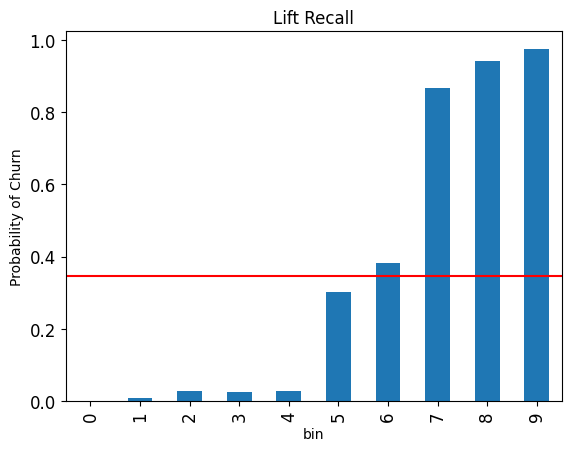

bin
0    0.001570
1    0.007412
2    0.028445
3    0.026138
4    0.027039
5    0.301371
6    0.380837
7    0.865400
8    0.940832
9    0.973950
Name: lift_positive, dtype: float64

In [ ]:
recall_bins = lift_recall['lift_positive']

recall_bins.plot.bar()
plt.title('Lift Recall')
plt.ylabel('Probability of Churn')

plt.xticks(rotation=90, fontsize=12)

plt.axhline(y = 0.346649, color = 'r', linestyle = '-')

plt.yticks(fontsize=12)

plt.show()

recall_bins

In [ ]:
# Obtener las probabilidades de las clases y mantener los índices
probs_train_rf_f1 = pd.DataFrame(rf_f1.predict_proba(X_train), index=X_train.index)
probs_test_rf_f1 = pd.DataFrame(rf_f1.predict_proba(X_test), index=X_test.index)


# Obtener las predicciones y mantener los índices
preds_train_rf_f1 = pd.DataFrame(rf_f1.predict(X_train), index=X_train.index)
preds_test_rf_f1 = pd.DataFrame(rf_f1.predict(X_test), index=X_test.index)

# Obtener las predicciones para crear la matriz de confusión y el classification report
prediction_rf_f1 = rf_f1.predict(X_test)

In [ ]:
# Extract the true labels from the DataFrame
y_test_labels = y_test['churn'].values
probs_test_labels = probs_test_rf_f1[1].values

# Calculate the lift values for different quantiles (bins)
lift_f1 = calc_lift(y_test_labels, probs_test_labels, bins=10)
print(lift_f1)

     lift_positive  lift_index  baseline
bin                                     
0         0.005334    1.538765  0.346649
1         0.008539    2.463341  0.346649
2         0.037141   10.714338  0.346649
3         0.014848    4.283230  0.346649
4         0.063405   18.290816  0.346649
5         0.294244   84.882448  0.346649
6         0.458515  132.270598  0.346649
7         0.860019  248.094847  0.346649
8         0.904221  260.846049  0.346649
9         0.971851  280.355712  0.346649


In [ ]:
import numpy as np

# Calculate quantiles to define bin boundaries
quantiles = np.percentile(probs_test_labels, np.linspace(0, 100, num=11))

# Print bin boundaries
for i in range(len(quantiles) - 1):
    print(f"Bin {i}: {quantiles[i]} - {quantiles[i+1]}")


Bin 0: 0.0011706013579732303 - 0.008697853406671526
Bin 1: 0.008697853406671526 - 0.136101785127086
Bin 2: 0.136101785127086 - 0.19311261536723162
Bin 3: 0.19311261536723162 - 0.19491796596895114
Bin 4: 0.19491796596895114 - 0.1977233942854198
Bin 5: 0.1977233942854198 - 0.22321095252129677
Bin 6: 0.22321095252129677 - 0.45781290434449856
Bin 7: 0.45781290434449856 - 0.5760773118636945
Bin 8: 0.5760773118636945 - 0.8244101501931533
Bin 9: 0.8244101501931533 - 0.9341568452738153


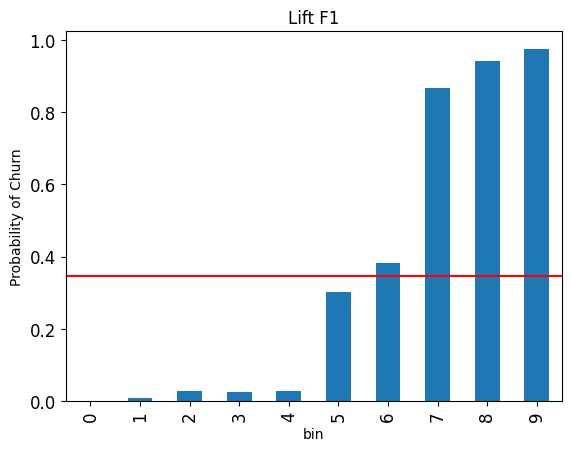

bin
0    0.005334
1    0.008539
2    0.037141
3    0.014848
4    0.063405
5    0.294244
6    0.458515
7    0.860019
8    0.904221
9    0.971851
Name: lift_positive, dtype: float64

In [ ]:
f1_bins = lift_f1['lift_positive']

recall_bins.plot.bar()
plt.title('Lift F1')
plt.ylabel('Probability of Churn')

plt.xticks(rotation=90, fontsize=12)

plt.axhline(y = 0.346649, color = 'r', linestyle = '-')

plt.yticks(fontsize=12)

plt.show()

f1_bins

In [ ]:
# Get the class probabilities and keep the indices
probs_train_rf_kappa = pd.DataFrame(rf_kappa.predict_proba(X_train), index=X_train.index)
probs_test_rf_kappa = pd.DataFrame(rf_kappa.predict_proba(X_test), index=X_test.index)

# Get the predictions and keep the indices
preds_train_rf_kappa = pd.DataFrame(rf_kappa.predict(X_train), index=X_train.index)
preds_test_rf_kappa = pd.DataFrame(rf_kappa.predict(X_test), index=X_test.index)

# Get the predictions to create the confusion matrix and classification report
prediction_rf_kappa = rf_kappa.predict(X_test)

In [ ]:
y_test_labels = y_test['churn'].values
probs_test_labels = probs_test_rf_kappa[1].values

lift_kappa = calc_lift(y_test_labels, probs_test_labels, bins=10)
print(lift_kappa)

# Cargar datos - Regresion Logistica

In [ ]:
path = '/content/drive/Shareddrives/Data_TFM/Dataset_Final/df_final_v7.csv'

df = pd.read_csv(path, sep=",", low_memory=False)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3201849 entries, 0 to 3201848
Data columns (total 26 columns):
 #   Column                                        Dtype  
---  ------                                        -----  
 0   date_day                                      object 
 1   unique_venue_id                               int64  
 2   antiguedad                                    float64
 3   saas_product_tw_connect                       float64
 4   saas_product_tw_pro                           float64
 5   n_channel                                     float64
 6   net_orders                                    float64
 7   net_aov                                       float64
 8   prepay                                        float64
 9   appointments_l30d                             float64
 10  online_appointments_rate                      float64
 11  is_tw_mp_listed_False                         float64
 12  is_tw_mp_listed_N/A                           float64
 1

## 1. Correlation Analysis

<ipython-input-4-204560dd766d>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()
<ipython-input-4-204560dd766d>:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
<ipython-input-4-204560dd766d>:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = n

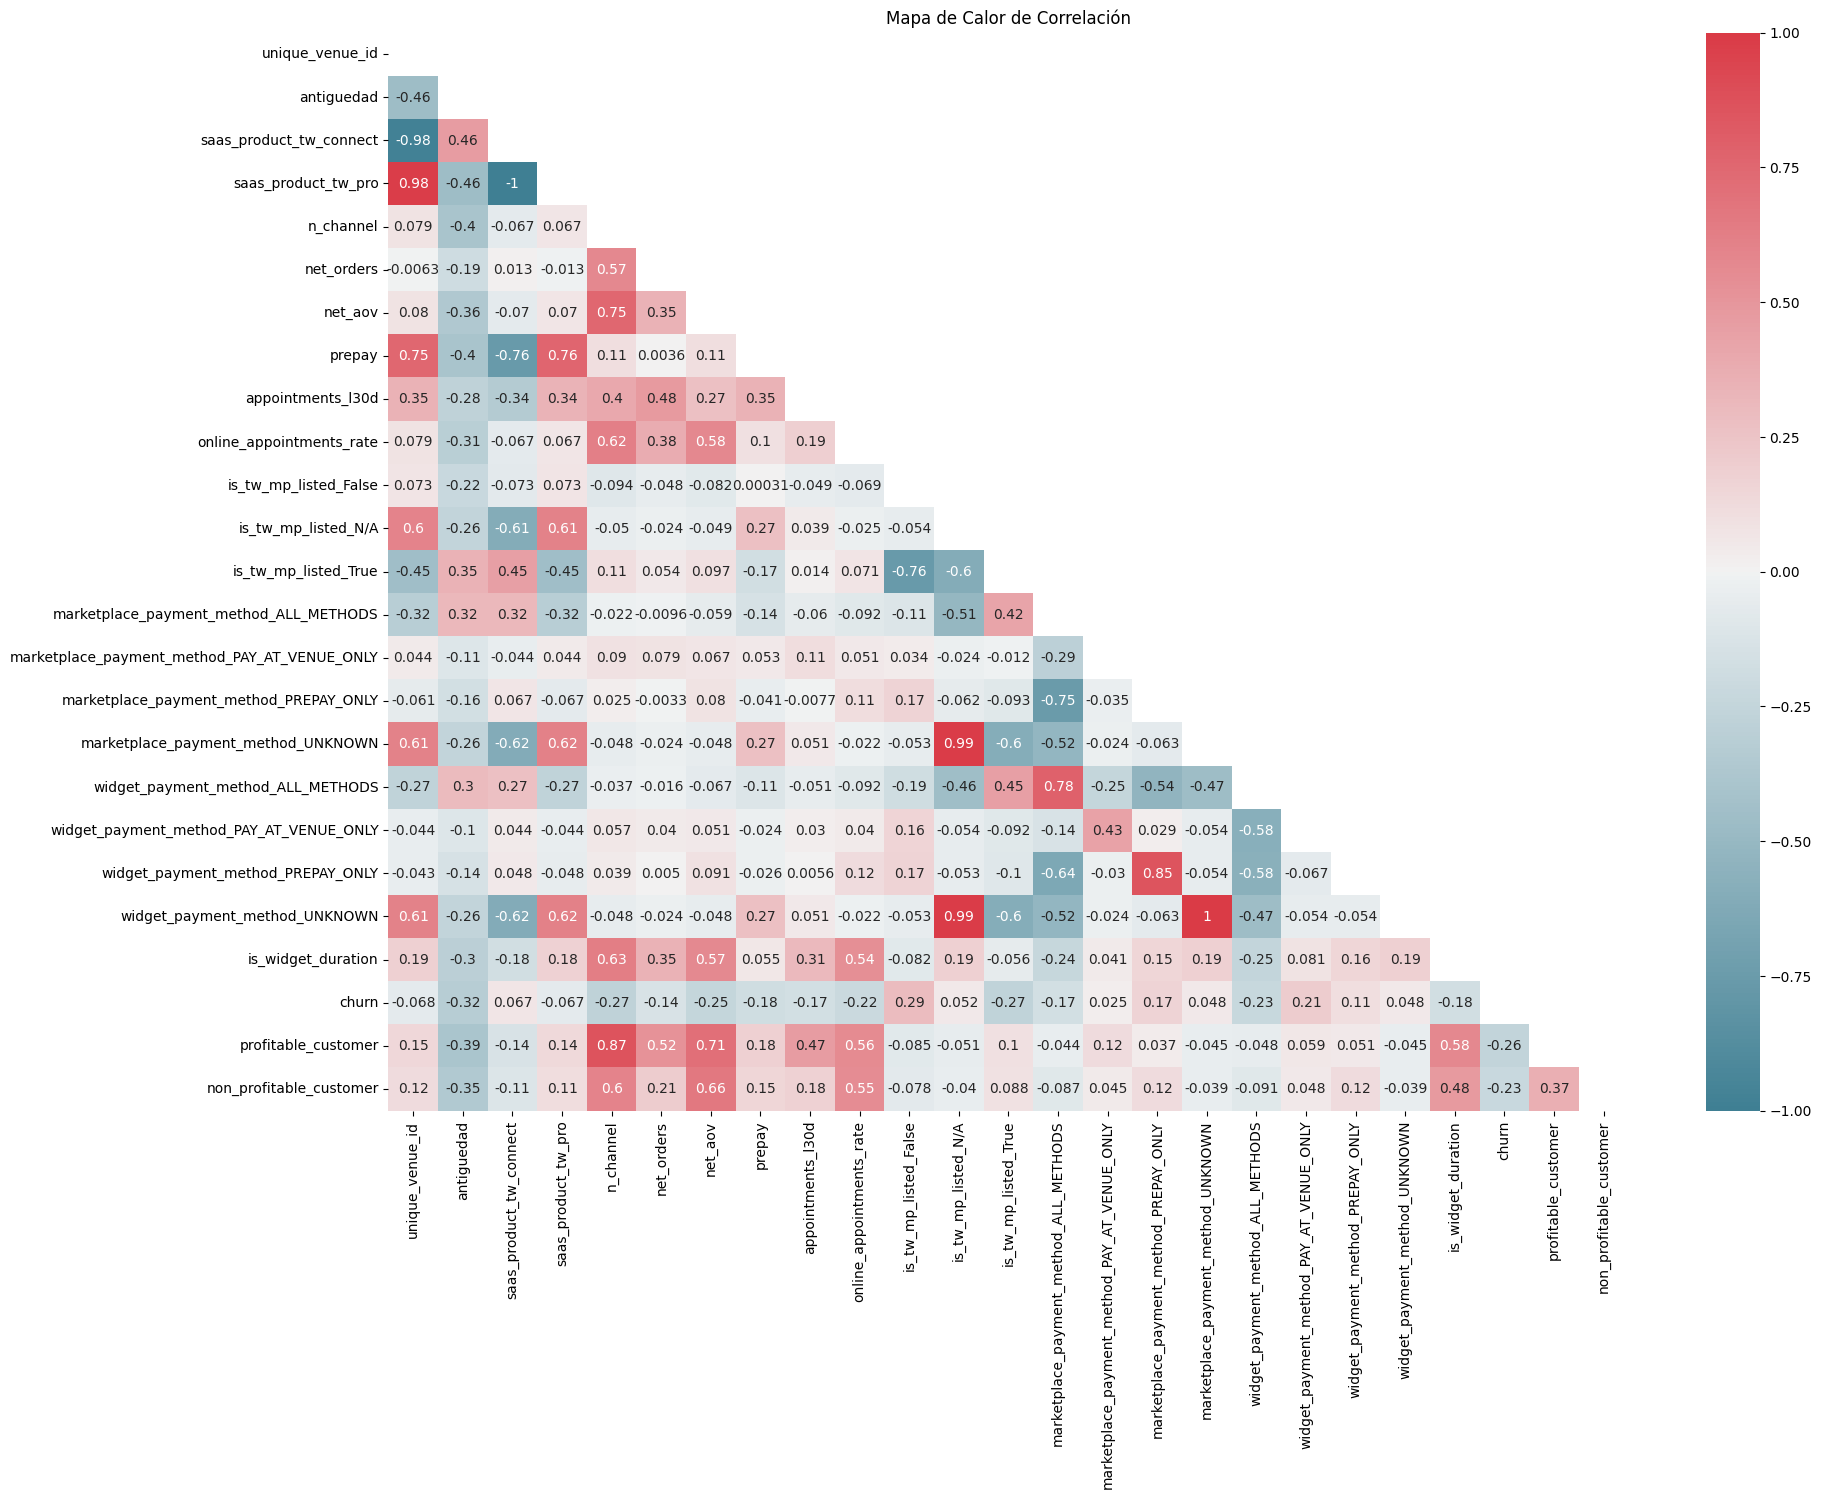

In [ ]:
# Correlation
corr_matrix = df.corr()

# Correlation Map
plt.figure(figsize=(20, 14))

# Define colormap with smoothed colors
cmap = sns.diverging_palette(220, 10, as_cmap=True)
#sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))

# Create heatmap with smoothed colors
sns.heatmap(corr_matrix, annot=True, mask=mask, cmap=cmap, vmin=-1, vmax=1)
plt.title('Mapa de Calor de Correlación')
plt.show()

We remove the following variables due to High Correlation:
- **saas_product_tw_connect**: As it is the opposite of saas_product_tw_pro, they are highly correlated.
- **is_tw_mp_listed_N/A**, **widget_payment_method_UNKNOWN**, **marketplace_payment_method_UNKNOWN**: Due to the high correlation between them.
- **non_profitable_customer**: As it is the opposite of profitable_customer, they are highly correlated.

In [ ]:
# Dropping Columns
df = df.drop('saas_product_tw_connect', axis='columns')
df = df.drop('is_tw_mp_listed_N/A', axis='columns')
df = df.drop('widget_payment_method_UNKNOWN', axis='columns')
df = df.drop('marketplace_payment_method_UNKNOWN', axis='columns')
df = df.drop('non_profitable_customer', axis='columns')

## Scaling Variables

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Variables to scale
numeric_variables = df[['antiquity', 'n_channel', 'net_orders', 'net_aov', 'appointments_l30d', 'is_widget_duration']]

# Create an instance of MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to your data and scale the variables
scaled_data = scaler.fit_transform(numeric_variables)

# Create a DataFrame with the scaled variables
scaled_df = pd.DataFrame(scaled_data, columns=numeric_variables.columns)

,antiguedad,n_channel,net_orders,net_aov,appointments_l30d,is_widget_duration
0,0.874317,0.0,0.0,0.0,0.0,0.0
1,0.786885,0.0,0.0,0.0,0.0,0.0
2,0.677596,0.0,0.0,0.0,0.0,0.0
3,0.874317,0.0,0.0,0.0,0.0,0.0
4,0.874317,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
3201844,0.000000,0.0,0.0,0.0,0.0,0.0
3201845,0.000000,0.0,0.0,0.0,0.0,0.0
3201846,0.000000,0.0,0.0,0.0,0.0,0.0
3201847,0.000000,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Merging scaled dataframes
df_2 = df.drop('antiguedad', axis='columns')
df_2 = df_2.drop('n_channel', axis='columns')
df_2 = df_2.drop('net_orders', axis='columns')
df_2 = df_2.drop('net_aov', axis='columns')
df_2 = df_2.drop('appointments_l30d', axis='columns')
df_2 = df_2.drop('is_widget_duration', axis='columns')

df_escalado = pd.concat([df_2, scaled_df], axis=1)

In [ ]:
df = df_escalado
df

,date_day,unique_venue_id,saas_product_tw_pro,prepay,online_appointments_rate,is_tw_mp_listed_False,is_tw_mp_listed_True,marketplace_payment_method_ALL_METHODS,marketplace_payment_method_PAY_AT_VENUE_ONLY,marketplace_payment_method_PREPAY_ONLY,...,widget_payment_method_PAY_AT_VENUE_ONLY,widget_payment_method_PREPAY_ONLY,churn,profitable_customer,antiguedad,n_channel,net_orders,net_aov,appointments_l30d,is_widget_duration
0,2021-06-01,11000000002,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.874317,0.0,0.0,0.0,0.0,0.0
1,2021-06-01,11000000004,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.786885,0.0,0.0,0.0,0.0,0.0
2,2021-06-01,11000000006,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.677596,0.0,0.0,0.0,0.0,0.0
3,2021-06-01,11000000007,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.874317,0.0,0.0,0.0,0.0,0.0
4,2021-06-01,11000000008,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.874317,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3201844,2023-05-01,12000048321,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3201845,2023-05-01,12000048322,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3201846,2023-05-01,12000048323,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3201847,2023-05-01,12000048324,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


## Creating and training model

In [ ]:
# Train/Test
X_train = df[df["date_day"] <= "2022-12-31"].drop(["churn"], axis=1)
X_test = df[(df["date_day"] > "2022-12-31") & (df["date_day"] < "2023-06-01")].drop(["churn"], axis=1)
y_train = df[df["date_day"] <= "2022-12-31"][["unique_venue_id", "date_day","churn"]]
y_test = df[(df["date_day"] > "2022-12-31") & (df["date_day"] < "2023-06-01")][["unique_venue_id", "date_day","churn"]]

# Index
X_train = X_train.set_index(['date_day', 'unique_venue_id'])
X_test = X_test.set_index(['date_day', 'unique_venue_id'])
y_train = y_train.set_index(['date_day', 'unique_venue_id'])
y_test = y_test.set_index(['date_day', 'unique_venue_id'])

## Logistic Regression


In [ ]:
from sklearn.linear_model import LogisticRegression

# Create an instance of the Logistic Regression model
logistic_regression = LogisticRegression()

# Train the model
logistic_regression.fit(X_train, y_train)

# Obtain class probabilities for both training and test sets
probs_train = pd.DataFrame(logistic_regression.predict_proba(X_train), index=X_train.index)
probs_test = pd.DataFrame(logistic_regression.predict_proba(X_test), index=X_test.index)

# Obtain predictions for both training and test sets
preds_train = pd.DataFrame(logistic_regression.predict(X_train), index=X_train.index)
preds_test = pd.DataFrame(logistic_regression.predict(X_test), index=X_test.index)

# Obtain predictions for creating the confusion matrix and classification report
prediction_churn_logistic_regression = logistic_regression.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Generate a classification report
classification_report_churn = classification_report(y_test, prediction_churn_logistic_regression)

print("\nClassification Report:")
print(classification_report_churn)


Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.96      0.91    489936
         1.0       0.89      0.71      0.79    259946

    accuracy                           0.87    749882
   macro avg       0.88      0.83      0.85    749882
weighted avg       0.87      0.87      0.87    749882



## Feature Importance

In [ ]:
import statsmodels.api as sm

# Calcular los residuos del modelo
residuals = y_train["churn"] - probs_train[1]

# Ajustar un modelo de regresión lineal a los residuos
model = sm.OLS(residuals, X_train)
result = model.fit()

# Obtener los p-valores de las características
p_values = result.pvalues

# Crear un DataFrame con las características y sus p-valores
p_values_df = pd.DataFrame({'Feature': X_train.columns, 'P-Value': p_values})

# Ordenar las características por p-valor en orden ascendente
p_values_df = p_values_df.sort_values(by='P-Value')

# Imprimir el DataFrame con los p-valores
print(p_values_df)

                                                                                   Feature  \
appointments_l30d                                                        appointments_l30d   
net_orders                                                                      net_orders   
net_aov                                                                            net_aov   
profitable_customer                                                    profitable_customer   
saas_product_tw_pro                                                    saas_product_tw_pro   
is_widget_duration                                                      is_widget_duration   
antiguedad                                                                      antiguedad   
is_tw_mp_listed_False                                                is_tw_mp_listed_False   
is_tw_mp_listed_True                                                  is_tw_mp_listed_True   
online_appointments_rate                                    

As we can see, the variable "appointments_l30d" has the smallest p-value, indicating high statistical significance and making it a highly important feature in the model.

Secondly, the variables "net_orders", "net_aov", "profitable_customer", "saas_product", "is_widget_duration", and "antiquity" also have very small p-values, rendering them highly significant in the model.

Thirdly, although the variables "is_tw_mp_listed", "online_appointments_rate", "prepay", and "n_channel" have p-values higher than the former ones, they are still statistically significant.

Lastly, the features related to payment methods ("marketplace_payment_method" and "widget_payment_method") have very high p-values, suggesting they are not statistically significant in the model.

## Creating and training model [Only Significant Variables]

In [ ]:
# Drop Columns
df = df.drop('marketplace_payment_method_PREPAY_ONLY', axis='columns')
df = df.drop('marketplace_payment_method_ALL_METHODS', axis='columns')
df = df.drop('marketplace_payment_method_PAY_AT_VENUE_ONLY', axis='columns')
df = df.drop('widget_payment_method_PAY_AT_VENUE_ONLY', axis='columns')
df = df.drop('widget_payment_method_PREPAY_ONLY', axis='columns')
df = df.drop('widget_payment_method_ALL_METHODS', axis='columns')

In [ ]:
# Train / Test
X_train = df[df["date_day"] <= "2022-12-31"].drop(["churn"], axis=1)
X_test = df[(df["date_day"] > "2022-12-31") & (df["date_day"] < "2023-06-01")].drop(["churn"], axis=1)
y_train = df[df["date_day"] <= "2022-12-31"][["unique_venue_id", "date_day","churn"]]
y_test = df[(df["date_day"] > "2022-12-31") & (df["date_day"] < "2023-06-01")][["unique_venue_id", "date_day","churn"]]

# Indixes
X_train = X_train.set_index(['date_day', 'unique_venue_id'])
X_test = X_test.set_index(['date_day', 'unique_venue_id'])
y_train = y_train.set_index(['date_day', 'unique_venue_id'])
y_test = y_test.set_index(['date_day', 'unique_venue_id'])

In [ ]:
from sklearn.linear_model import LogisticRegression

# Create an instance of the Logistic Regression model
logistic_regression = LogisticRegression()

# Train the model
logistic_regression.fit(X_train, y_train)

# Obtain class probabilities for both training and test sets
probs_train = pd.DataFrame(logistic_regression.predict_proba(X_train), index=X_train.index)
probs_test = pd.DataFrame(logistic_regression.predict_proba(X_test), index=X_test.index)

# Obtain predictions for both training and test sets
preds_train = pd.DataFrame(logistic_regression.predict(X_train), index=X_train.index)
preds_test = pd.DataFrame(logistic_regression.predict(X_test), index=X_test.index)

# Obtain predictions for creating the confusion matrix and classification report
prediction_churn_logistic_regression = logistic_regression.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Generate a classification report
classification_report_churn = classification_report(y_test, prediction_churn_logistic_regression)

print("\nClassification Report:")
print(classification_report_churn)


Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.95      0.90    489936
         1.0       0.89      0.70      0.78    259946

    accuracy                           0.87    749882
   macro avg       0.87      0.83      0.84    749882
weighted avg       0.87      0.87      0.86    749882



## Saving Model

In [ ]:
import pickle

# F-1 Score
# Guardar el modelo en un archivo con extensión .pkl
path = '/content/drive/Shareddrives/Data_TFM/Notebooks/logistic_regression.pkl'
with open(path, 'wb') as f:
    pickle.dump(logistic_regression, f)

**Uploading Model**

In [ ]:
# Ruta completa del archivo donde guardaste el modelo
#path='/content/drive/Shareddrives/Data_TFM/Notebooks/model_churn.pkl'

# Cargar el modelo desde el archivo .pkl
#with open(path, 'rb') as f:
#    model_churn_random_forest = pickle.load(f)

## LIFT

In [ ]:
pip install scikit-plot

**Importamos los modelos**

In [ ]:
def calc_lift(y_test, probs_test, bins=10):
    """
    Calculate the lift given true labels and prediction. Note this only works for a binary classifier.
    Parameters
    -------------------
    y:    a 1-d Numpy array or Pandas Series of the true label
    y_prob: predicted probablity of positive class
    bins: number of equal sized quantiles to divide observations across (default is 10).
    """

    df = pd.DataFrame({'actual': y_test, 'pred_prob': probs_test})

    n_positives = df['actual'].sum()
    n_obs = df.shape[0]
    # baseline with a random classifier
    baseline = n_positives / float(n_obs)

    df['bin'] = pd.qcut(df['pred_prob'], bins, labels=False)
    grouped_df = df.groupby('bin')
    lift_positive = grouped_df['actual'].sum() / grouped_df['actual'].count()
    lift_index = (lift_positive/baseline)*100

    lift_df = pd.DataFrame({'lift_positive':lift_positive,
                            'lift_index':lift_index,
                            'baseline':baseline})

    return lift_df

In [ ]:
# Extract the true labels from the DataFrame
y_test_labels = y_test['churn'].values
probs_test_labels = probs_test[1].values

# Calculate the lift values for different quantiles (bins)
lift_f1 = calc_lift(y_test_labels, probs_test_labels, bins=10)
print(lift_f1)

     lift_positive  lift_index  baseline
bin                                     
0         0.004681    1.350266  0.346649
1         0.010974    3.165840  0.346649
2         0.030504    8.799736  0.346649
3         0.022514    6.494693  0.346649
4         0.022346    6.446193  0.346649
5         0.139628   40.279228  0.346649
6         0.607342  175.203550  0.346649
7         0.846500  244.194927  0.346649
8         0.920946  265.670951  0.346649
9         0.879282  253.651883  0.346649


In [ ]:
import numpy as np

# Calculate quantiles to define bin boundaries
quantiles = np.percentile(probs_test_labels, np.linspace(0, 100, num=11))

# Print bin boundaries
for i in range(len(quantiles) - 1):
    print(f"Bin {i}: {quantiles[i]} - {quantiles[i+1]}")

Bin 0: 1.6569797831839557e-18 - 3.1297218294268833e-07
Bin 1: 3.1297218294268833e-07 - 0.0029006241403872414
Bin 2: 0.0029006241403872414 - 0.01315440598505069
Bin 3: 0.01315440598505069 - 0.023918595960882617
Bin 4: 0.023918595960882617 - 0.047828964406943675
Bin 5: 0.047828964406943675 - 0.22925285996026604
Bin 6: 0.22925285996026604 - 0.42574470880084736
Bin 7: 0.42574470880084736 - 0.7142274776523907
Bin 8: 0.7142274776523907 - 0.9428643042334542
Bin 9: 0.9428643042334542 - 0.9998765778379237


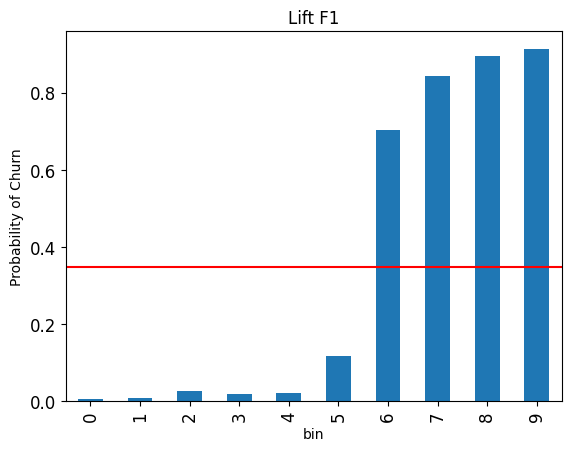

bin
0    0.005587
1    0.006948
2    0.026887
3    0.018681
4    0.019911
5    0.116529
6    0.702666
7    0.843206
8    0.894478
9    0.912897
Name: lift_positive, dtype: float64

In [ ]:
f1_bins = lift_f1['lift_positive']

f1_bins.plot.bar()
plt.title('Lift F1')
plt.ylabel('Probability of Churn')

plt.xticks(rotation=90, fontsize=12)

plt.axhline(y = 0.346649, color = 'r', linestyle = '-')

plt.yticks(fontsize=12)

plt.show()

f1_bins

In [ ]:
import numpy as np

def calculate_lpr_li(true_labels, predicted_probs, bins=10):
    # Calculate the lift values
    lift = np.zeros(bins)
    total_positives = np.sum(true_labels)
    total_samples = len(true_labels)

    quantiles = np.linspace(0, 1, bins + 1)
    quantiles = np.percentile(predicted_probs, quantiles * 100)

    for i in range(bins):
        mask = (predicted_probs >= quantiles[i]) & (predicted_probs < quantiles[i + 1])
        lift[i] = np.sum(true_labels[mask]) / (total_positives / bins)

    # Calculate Lift Positive Rate (LPR)
    lpr = lift / (total_positives / total_samples)

    # Calculate Lift Index (LI)
    baseline = np.linspace(1, bins, bins)
    li = lift / baseline

    return lpr, li


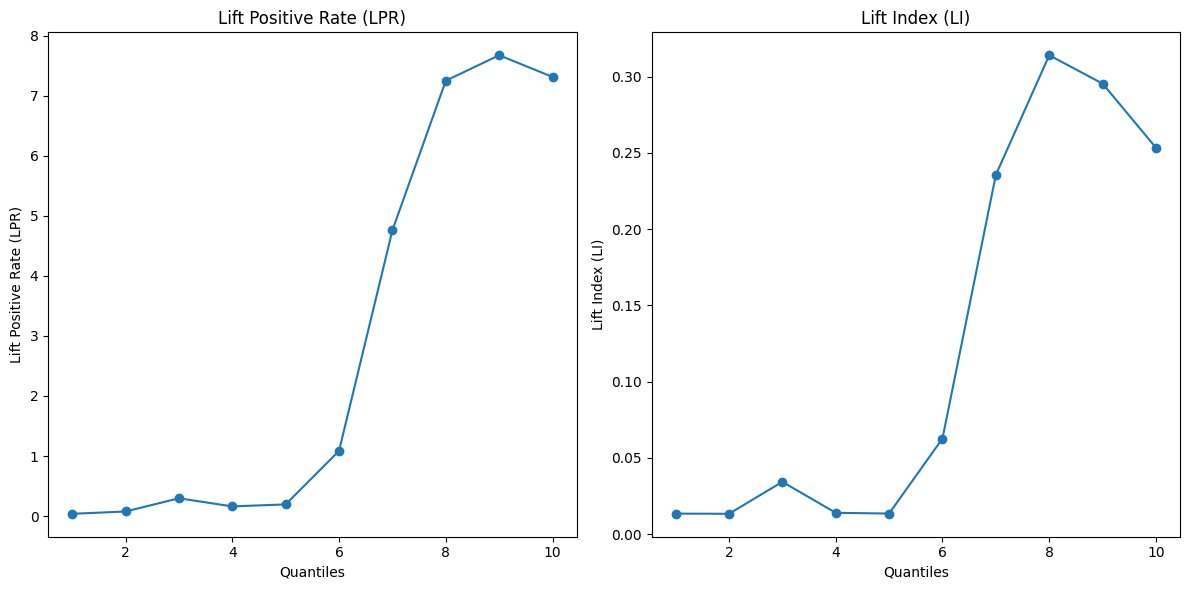

In [ ]:
import matplotlib.pyplot as plt

# Calculate LPR and LI
lpr, li = calculate_lpr_li(y_test_labels, probs_test_labels, bins=10)

# Create plots
plt.figure(figsize=(12, 6))

# Plot Lift Positive Rate (LPR)
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, 11), lpr, marker='o')
plt.xlabel('Quantiles')
plt.ylabel('Lift Positive Rate (LPR)')
plt.title('Lift Positive Rate (LPR)')

# Plot Lift Index (LI)
plt.subplot(1, 2, 2)
plt.plot(np.arange(1, 11), li, marker='o')
plt.xlabel('Quantiles')
plt.ylabel('Lift Index (LI)')
plt.title('Lift Index (LI)')

plt.tight_layout()
plt.show()


In [ ]:
import statsmodels.api as sm

# Calcular los residuos del modelo
residuals = y_train["churn"] - probs_train[1]

# Ajustar un modelo de regresión lineal a los residuos
model = sm.OLS(residuals, X_train)
result = model.fit()

# Obtener los p-valores de las características
p_values = result.pvalues

# Crear un DataFrame con las características y sus p-valores
p_values_df = pd.DataFrame({'Feature': X_train.columns, 'P-Value': p_values})

# Ordenar las características por p-valor en orden ascendente
p_values_df = p_values_df.sort_values(by='P-Value')

# Imprimir el DataFrame con los p-valores
print(p_values_df)

                                           Feature        P-Value
appointments_l30d                appointments_l30d  1.392530e-116
net_aov                                    net_aov   6.107919e-31
net_orders                              net_orders   8.040965e-25
profitable_customer            profitable_customer   2.002290e-08
is_widget_duration              is_widget_duration   7.168138e-04
is_tw_mp_listed_True          is_tw_mp_listed_True   9.859789e-04
prepay                                      prepay   1.087335e-03
antiguedad                              antiguedad   3.113933e-03
saas_product_tw_pro            saas_product_tw_pro   4.131167e-03
n_channel                                n_channel   4.385631e-01
online_appointments_rate  online_appointments_rate   4.465370e-01
is_tw_mp_listed_False        is_tw_mp_listed_False   7.644843e-01


As we can see:
- **appointments_l30d** has the smallest p-value, indicating high statistical significance and making it a highly important feature in the model.
- **net_orders**, **net_aov**, **profitable_customer**, **saas_product**, **is_widget_duration**, and **antiquity** also have very small p-values, rendering them highly significant in the model.
- Although **is_tw_mp_listed**, **online_appointments_rate**, **prepay**, and **n_channel** have higher p-values, they are still statistically significant.
- Features related to payment methods (**marketplace_payment_method** and **widget_payment_method**) have very high p-values, suggesting they are not statistically significant in the model.

# Uploading data - XGBoost


In [ ]:
path = '/content/drive/Shareddrives/Data_TFM/Dataset_Final/df_final_v7.csv'

df = pd.read_csv(path, sep=",", low_memory=False)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3201849 entries, 0 to 3201848
Data columns (total 26 columns):
 #   Column                                        Dtype  
---  ------                                        -----  
 0   date_day                                      object 
 1   unique_venue_id                               int64  
 2   antiguedad                                    float64
 3   saas_product_tw_connect                       float64
 4   saas_product_tw_pro                           float64
 5   n_channel                                     float64
 6   net_orders                                    float64
 7   net_aov                                       float64
 8   prepay                                        float64
 9   appointments_l30d                             float64
 10  online_appointments_rate                      float64
 11  is_tw_mp_listed_False                         float64
 12  is_tw_mp_listed_N/A                           float64
 1

## Creating and traininf model v1.0


In [ ]:
# Crear los conjuntos de train y test
X_train = df[df["date_day"] <= "2022-12-31"].drop(["churn"], axis=1)
X_test = df[(df["date_day"] > "2022-12-31") & (df["date_day"] < "2023-06-01")].drop(["churn"], axis=1)
y_train = df[df["date_day"] <= "2022-12-31"][["unique_venue_id", "date_day","churn"]]
y_test = df[(df["date_day"] > "2022-12-31") & (df["date_day"] < "2023-06-01")][["unique_venue_id", "date_day","churn"]]

# Crear los index
X_train = X_train.set_index(['date_day', 'unique_venue_id'])
X_test = X_test.set_index(['date_day', 'unique_venue_id'])
y_train = y_train.set_index(['date_day', 'unique_venue_id'])
y_test = y_test.set_index(['date_day', 'unique_venue_id'])

We have created the variable **month** to add it to the model since in the EDA we observed seasonality.
We have created the train and test sets using **date_day** to segment the sets based on the date due to seasonality.
- **Train**: The train set contains all data from 2021 and 2022.
- **Test**: The test set contains all data from January 2023 to May 2023.
- **Validation**: The validation set will start from June 2023.
We have created the indices **date_day** and **unique_venue_id** to keep the sets ordered.

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report

# Crear una instancia del Clasificador XGBoost
xgb_clf = xgb.XGBClassifier(max_depth=5, min_child_weight=1, n_estimators=50, learning_rate=0.1)

# Entrenar el modelo
modelo_churn_xgb = xgb_clf.fit(X_train, y_train)

# Obtener las probabilidades de las clases y mantener los índices
probs_train = pd.DataFrame(modelo_churn_xgb.predict_proba(X_train), index=X_train.index)
probs_test = pd.DataFrame(modelo_churn_xgb.predict_proba(X_test), index=X_test.index)

# Obtener las predicciones y mantener los índices
preds_train = pd.DataFrame(modelo_churn_xgb.predict(X_train), index=X_train.index)
preds_test = pd.DataFrame(modelo_churn_xgb.predict(X_test), index=X_test.index)

# Obtener predicciones para crear la matriz de confusión y el reporte de clasificación
prediccion_churn_xgb = modelo_churn_xgb.predict(X_test)

In [ ]:
# Crear reporte de clasificación
reporte_clasificacion = classification_report(y_test, prediccion_churn_xgb)
print(reporte_clasificacion)

- We have created 2 different dataframes for both the train and test sets:
    - **probs**: Contains the probabilities that the record is churn (0-1).
    - **preds**: Contains the prediction that the record is churn.

## Searchgrid: F-1 [tiempo modelo final]

In [ ]:
# Definir los hiperparámetros a ajustar
param_grid = {
    'n_estimators': [3, 6, 9, 50, 100],
    'max_depth': [2, 5, 10],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1],
    'min_child_weight': [1, 5, 10]
}

# Define custom scorers
scorers = {
    #'recall': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score)#,
    #'kappa': make_scorer(cohen_kappa_score)
}

# Perform grid search for each metric
best_models = {}
execution_times = {}

for metric in scorers:
    start_time = time.time()  # Registrar el tiempo de inicio
    grid_search = GridSearchCV(estimator=modelo_churn_xgb, param_grid=param_grid, cv=3, scoring=scorers[metric], refit=metric)
    # grid_search.fit(X_train, y_train)
    # /usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
    # estimator.fit(X_train, y_train, **fit_params)
    grid_search.fit(X_train, y_train['churn'].values.ravel())
    end_time = time.time()  # Registrar el tiempo de finalización

    execution_time = end_time - start_time
    execution_times[metric] = execution_time

    best_models[metric] = {
        'best_params': grid_search.best_params_,
        'best_model': grid_search.best_estimator_
    }

# Imprimir los resultados
for metric in best_models:
    print(f"Mejores parámetros encontrados para {metric}: {best_models[metric]['best_params']}")
    print(f"Mejor modelo encontrado para {metric}: {best_models[metric]['best_model']}")
    print(f"Tiempo de ejecución para {metric}: {execution_times[metric]} segundos\n")

**Summary:**

**F1-Score:**
* Best parameters found for f1_score: {'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 100}
* Best model found for f1_score: XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, early_stopping_rounds=None, enable_categorical=False, eval_metric=None, feature_types=None, gamma=None, gpu_id=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=0.1, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=2, max_leaves=None,
 min_child_weight=1, missing=nan, monotone_constraints=None, n_estimators=100, n_jobs=None, num_parallel_tree=None, predictor=None, random_state=None, ...}
* Execution time for f1_score: 4232.438445091248 seconds

## Improved Models 

**F-1 Score**

In [ ]:
import xgboost as xgb

# F1-Score

start_time = time.time()  # Registrar el tiempo de inicio

# Crear la instancia del Random Forest
xgboost_f1 = xgb.XGBClassifier(max_depth=2, learning_rate=0.1, n_estimators=100, min_child_weight=1)

# Entrenar el modelo
xgboost_f1.fit(X_train, y_train)

# Obtener las probabilidades de las clases y mantener los índices
probs_train_xgboost_f1 = pd.DataFrame(xgboost_f1.predict_proba(X_train), index=X_train.index)
probs_test_xgboost_f1 = pd.DataFrame(xgboost_f1.predict_proba(X_test), index=X_test.index)


# Obtener las predicciones y mantener los índices
preds_train_xgboost_f1 = pd.DataFrame(xgboost_f1.predict(X_train), index=X_train.index)
preds_test_xgboost_f1 = pd.DataFrame(xgboost_f1.predict(X_test), index=X_test.index)

# Obtener las predicciones para crear la matriz de confusión y el classification report
prediction_xgboost_f1 = xgboost_f1.predict(X_test)

end_time = time.time()  # Registrar el tiempo de finalización

# Tiempo Entrenamiento Modelo
execution_time = end_time - start_time
print(execution_time, "segundos o ",execution_time/60, "minutos")

136.833753824234 segundos o  2.2805625637372335 minutos


In [ ]:
# Crear reporte de clasificación
reporte_clasificacion = classification_report(y_test, prediction_xgboost_f1)
print(reporte_clasificacion)

              precision    recall  f1-score   support

         0.0       0.89      0.96      0.92    489936
         1.0       0.90      0.77      0.83    259946

    accuracy                           0.89    749882
   macro avg       0.90      0.86      0.88    749882
weighted avg       0.89      0.89      0.89    749882



In [ ]:
import xgboost as xgb

# F1-Score

start_time = time.time()  # Registrar el tiempo de inicio

# Crear la instancia del Random Forest
xgboost_f1 = xgb.XGBClassifier(max_depth=2, learning_rate=0.15, n_estimators=150)

# Entrenar el modelo
xgboost_f1.fit(X_train, y_train)

# Obtener las probabilidades de las clases y mantener los índices
probs_train_xgboost_f1 = pd.DataFrame(xgboost_f1.predict_proba(X_train), index=X_train.index)
probs_test_xgboost_f1 = pd.DataFrame(xgboost_f1.predict_proba(X_test), index=X_test.index)


# Obtener las predicciones y mantener los índices
preds_train_xgboost_f1 = pd.DataFrame(xgboost_f1.predict(X_train), index=X_train.index)
preds_test_xgboost_f1 = pd.DataFrame(xgboost_f1.predict(X_test), index=X_test.index)

# Obtener las predicciones para crear la matriz de confusión y el classification report
prediction_xgboost_f1 = xgboost_f1.predict(X_test)

end_time = time.time()  # Registrar el tiempo de finalización

# Tiempo Entrenamiento Modelo
execution_time = end_time - start_time
print(execution_time, "segundos o ",execution_time/60, "minutos")

209.64395117759705 segundos o  3.4940658529599506 minutos


## Guardamos Modelos

In [ ]:
import pickle

# F-1 Score
# Guardar el modelo en un archivo con extensión .pkl
path = '/content/drive/Shareddrives/Data_TFM/Notebooks/xgboost_f1.pkl'
with open(path, 'wb') as f:
    pickle.dump(xgboost_f1, f)

**Cargar Modelo**

In [ ]:
# Ruta completa del archivo donde guardaste el modelo
#path='/content/drive/Shareddrives/Data_TFM/Notebooks/model_churn.pkl'

# Cargar el modelo desde el archivo .pkl
#with open(path, 'rb') as f:
#    model_churn_random_forest = pickle.load(f)

## Evaluar el modelo (métrica propia)

Vamos a crear una métrica propia llamada "Accuracy_top_prob" que va a medir el porcentaje de aciertos que hemos obtenido en los registros con una probabilidad de hacer churn del 100%. Aplicaremos esta métrica al conjunto de train y test.



In [ ]:
# Unificar los DataFrames
df_train = pd.concat([probs_train, preds_train, y_train], axis=1)
df_train = df_train.set_axis(["prob_0", "prob_1", "pred", "churn"], axis=1)

print("La cantidad de rows del conjunto train con una probabilidad de churn del 100% es:", len(df_train[df_train["prob_1"] == 1]))
print("El porcentaje de rows del conjunto train con una probabilidad de churn del 100% es:", len(df_train[df_train["prob_1"] == 1])/len(df_train))
print("La cantidad de rows del conjunto train con una probabilidad de churn del 0% es:",len(df_train[df_train["prob_1"] == 0]))
print("El porcentaje de rows del conjunto train con una probabilidad de churn del 0% es:",len(df_train[df_train["prob_1"] == 0])/len(df_train))

df_train

La cantidad de rows del conjunto train con una probabilidad de churn del 100% es: 0
El porcentaje de rows del conjunto train con una probabilidad de churn del 100% es: 0.0
La cantidad de rows del conjunto train con una probabilidad de churn del 0% es: 0
El porcentaje de rows del conjunto train con una probabilidad de churn del 0% es: 0.0


prob_0    prob_1  pred  churn
date_day   unique_venue_id                                 
2021-06-01 11000000002      0.085441  0.914559     1    1.0
           11000000004      0.980040  0.019960     0    0.0
           11000000006      0.972245  0.027755     0    0.0
           11000000007      0.940386  0.059614     0    0.0
           11000000008      0.940386  0.059614     0    0.0
...                              ...       ...   ...    ...
2022-12-01 13026415610      0.018986  0.981014     1    1.0
           13026415939      0.020512  0.979488     1    1.0
           13026416171      0.990954  0.009046     0    0.0
           13026416368      0.991599  0.008401     0    0.0
           13026416403      0.020316  0.979684     1    1.0

[2451967 rows x 4 columns]

In [ ]:
# Unificar los DataFrames
df_test = pd.concat([probs_test, preds_test, y_test], axis=1)
df_test = df_test.set_axis(["prob_0", "prob_1", "pred", "churn"], axis=1)

print("La cantidad de rows del conjunto test con una probabilidad de churn del 100% es:", len(df_test[df_test["prob_1"] == 1]))
print("El porcentaje de rows del conjunto test con una probabilidad de churn del 100% es:", len(df_test[df_test["prob_1"] == 1])/len(df_test))
print("La cantidad de rows del conjunto test con una probabilidad de churn del 0% es:",len(df_test[df_test["prob_1"] == 0]))
print("El porcentaje de rows del conjunto test con una probabilidad de churn del 0% es:",len(df_test[df_test["prob_1"] == 0])/len(df_test))

df_test

La cantidad de rows del conjunto test con una probabilidad de churn del 100% es: 0
El porcentaje de rows del conjunto test con una probabilidad de churn del 100% es: 0.0
La cantidad de rows del conjunto test con una probabilidad de churn del 0% es: 0
El porcentaje de rows del conjunto test con una probabilidad de churn del 0% es: 0.0


prob_0    prob_1  pred  churn
date_day   unique_venue_id                                 
2023-01-01 11000000002      0.075421  0.924579     1    1.0
           11000000003      0.075421  0.924579     1    1.0
           11000000004      0.937296  0.062704     0    0.0
           11000000005      0.019269  0.980731     1    1.0
           11000000006      0.980040  0.019960     0    0.0
...                              ...       ...   ...    ...
2023-05-01 12000048321      0.997134  0.002866     0    0.0
           12000048322      0.997134  0.002866     0    0.0
           12000048323      0.997134  0.002866     0    0.0
           12000048324      0.997134  0.002866     0    0.0
           12000048325      0.997134  0.002866     0    0.0

[749882 rows x 4 columns]

## Model evaluation (Confusion Matrix)

[Text(0, 0, 'Not Churn'), Text(0, 1, 'Churn')]

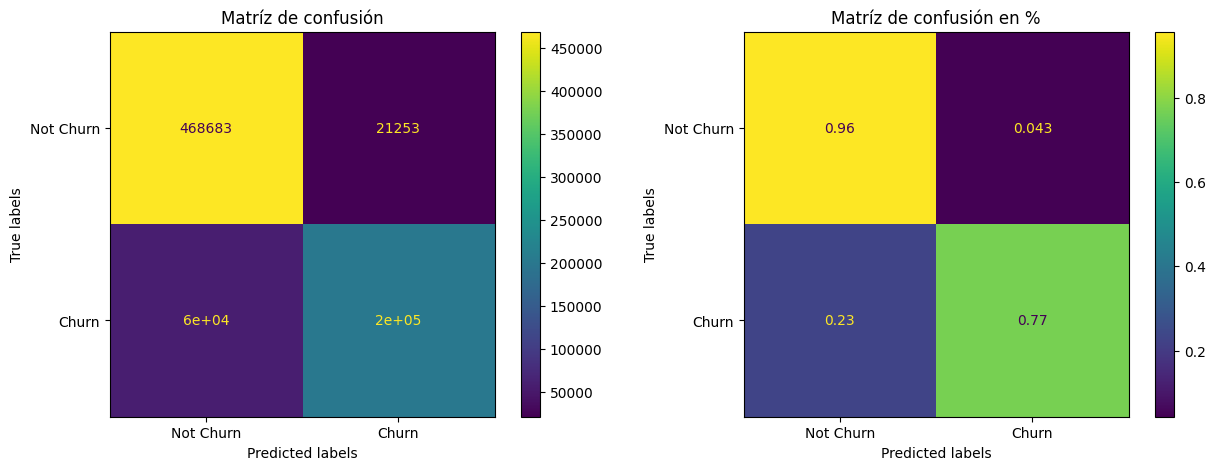

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Matriz de confusión
cm = confusion_matrix(y_test, prediction_xgboost_f1)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=ax1)
ax1.set_title("Matríz de confusión")
ax1.set_xlabel('Predicted labels')
ax1.set_ylabel('True labels')
ax1.set_xticklabels(['Not Churn', 'Churn'])
ax1.set_yticklabels(['Not Churn', 'Churn'])

# Matriz de confusión en porcentaje
cm_percent = cm / cm.sum(axis=1, keepdims=True)
ConfusionMatrixDisplay(confusion_matrix=cm_percent).plot(ax=ax2)
ax2.set_title("Matríz de confusión en %")
ax2.set_xlabel('Predicted labels')
ax2.set_ylabel('True labels')
ax2.set_xticklabels(['Not Churn', 'Churn'])
ax2.set_yticklabels(['Not Churn', 'Churn'])

In [ ]:
print(classification_report(y_test, prediccion_churn_xgb))

              precision    recall  f1-score   support

         0.0       0.89      0.97      0.92    489936
         1.0       0.92      0.77      0.84    259946

    accuracy                           0.90    749882
   macro avg       0.90      0.87      0.88    749882
weighted avg       0.90      0.90      0.90    749882



The accuracy is high for both classes. This indicates that the model has a good ability to correctly predict positive and negative cases in both classes. However, the recall is slightly lower for class "1", suggesting that the model may have more difficulty identifying churn cases correctly.

In summary, although the model shows good results in terms of precision and recall for both classes, it is important to consider that the recall for the minority class may be of greater relevance in an imbalanced churn problem.

Lastly, it's worth mentioning that we will attempt to find the best hyperparameters based on improving recall.

## Feature Importance

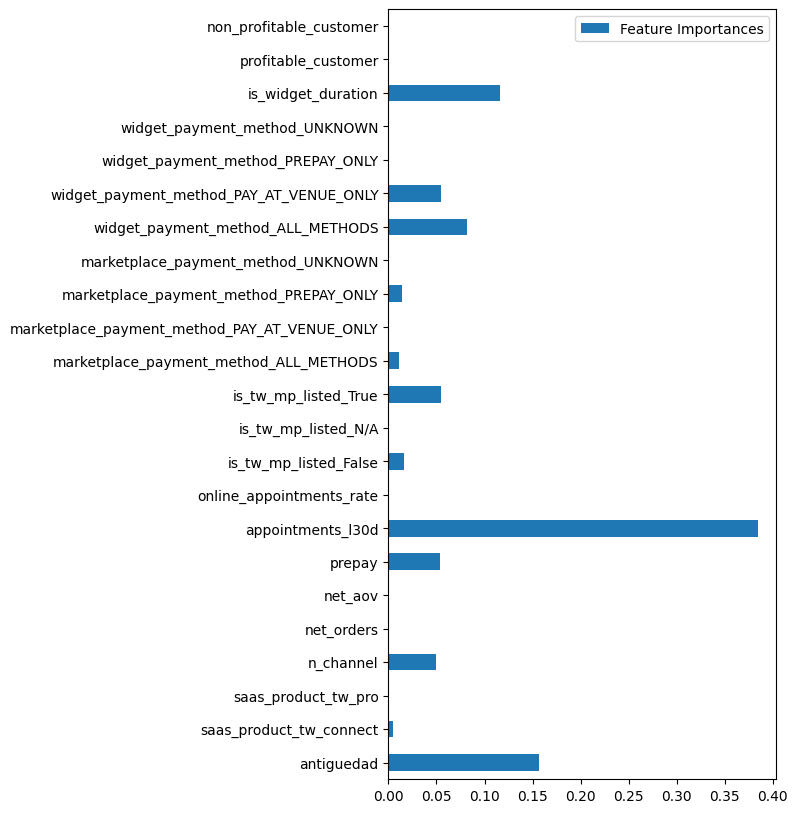

In [ ]:
df_imp = pd.DataFrame(xgboost_f1.feature_importances_.reshape(1,-1), columns=X_train.columns, index=["Feature Importances"])
df_imp.T.plot.barh(figsize=(5, 10))
plt.legend()
# Save the figure
plt.savefig('feature_importances.png')

<Figure size 1000x800 with 0 Axes>

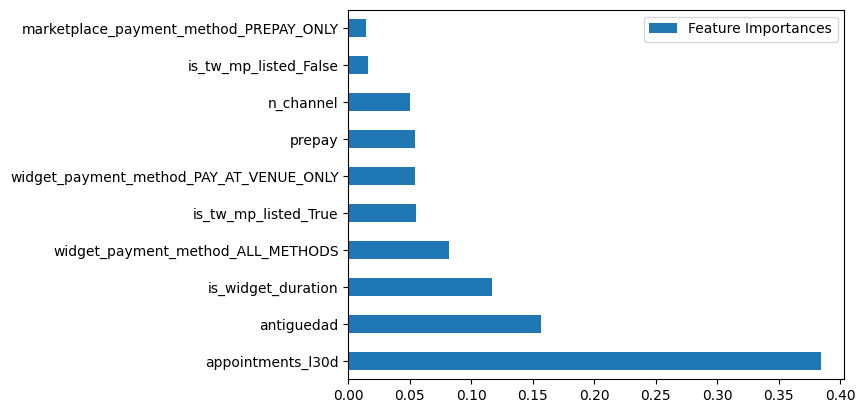

In [ ]:
# Transponer el DataFrame y seleccionar las 10 características más importantes
top_10_imp = df_imp.T.nlargest(10, "Feature Importances")

# Graficar las 10 características más importantes
plt.figure(figsize=(10, 8))
top_10_imp.plot.barh()
plt.legend()

# Mostrar el gráfico
plt.show()

In [ ]:
#from google.colab import files
# Download the image
#files.download('feature_importances.png')

Variables with most feature importance are: 
- Antiguedad
- Is_widget_duration_bin_not_enabled
- Appointments_l30d
- Loyal
- Widget_payment_method_all_methods

<Figure size 1000x800 with 0 Axes>

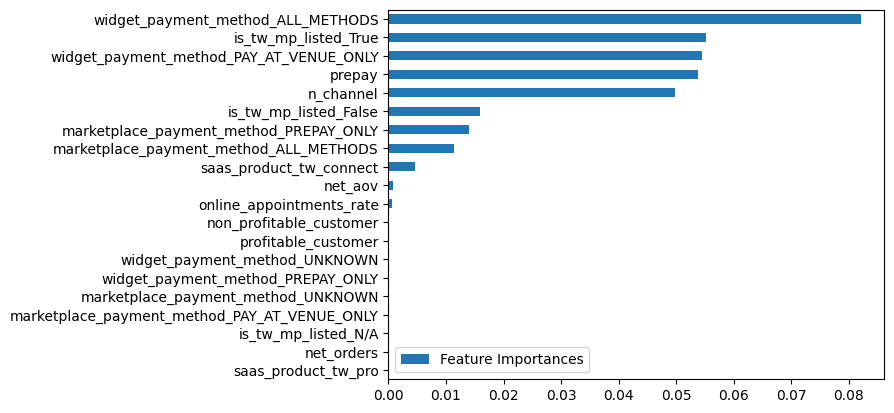

In [ ]:
# Seleccionar las 20 características menos importantes
bottom_20_imp = df_imp.T.nsmallest(20, "Feature Importances")

# Graficar las 20 características menos importantes
plt.figure(figsize=(10, 8))
bottom_20_imp.plot.barh()
plt.legend()

# Mostrar el gráfico
plt.show()

### LIFT

In [ ]:
pip install scikit-plot

**Importamos los modelos**

In [ ]:
# Ruta completa del archivo donde guardaste el modelo
path_f1 = '/content/drive/Shareddrives/Data_TFM/Notebooks/xgboost_f1.pkl'

# Cargar el modelo desde el archivo .pkl
with open(path_f1, 'rb') as f:
    rf_f1 = pickle.load(f)

In [ ]:
def calc_lift(y_test, probs_test, bins=10):
    """
    Calculate the lift given true labels and prediction. Note this only works for a binary classifier.
    Parameters
    -------------------
    y:    a 1-d Numpy array or Pandas Series of the true label
    y_prob: predicted probablity of positive class
    bins: number of equal sized quantiles to divide observations across (default is 10).
    """

    df = pd.DataFrame({'actual': y_test, 'pred_prob': probs_test})

    n_positives = df['actual'].sum()
    n_obs = df.shape[0]
    # baseline with a random classifier
    baseline = n_positives / float(n_obs)

    df['bin'] = pd.qcut(df['pred_prob'], bins, labels=False)
    grouped_df = df.groupby('bin')
    lift_positive = grouped_df['actual'].sum() / grouped_df['actual'].count()
    lift_index = (lift_positive/baseline)*100

    lift_df = pd.DataFrame({'lift_positive':lift_positive,
                            'lift_index':lift_index,
                            'baseline':baseline})

    return lift_df

Until now, we only looked at nice charts. But usually you're interested in the lift score as well. The definition is pretty simple:

lift = ( predicted rate / average rate )

In [ ]:
# Obtener las probabilidades de las clases y mantener los índices
probs_train_xgboost_f1 = pd.DataFrame(xgboost_f1.predict_proba(X_train), index=X_train.index)
probs_test_xgboost_f1 = pd.DataFrame(xgboost_f1.predict_proba(X_test), index=X_test.index)


# Obtener las predicciones y mantener los índices
preds_train_xgboost_f1 = pd.DataFrame(xgboost_f1.predict(X_train), index=X_train.index)
preds_test_xgboost_f1 = pd.DataFrame(xgboost_f1.predict(X_test), index=X_test.index)

# Obtener las predicciones para crear la matriz de confusión y el classification report
prediction_xgboost_f1 = xgboost_f1.predict(X_test)

In [ ]:
# Extract the true labels from the DataFrame
y_test_labels = y_test['churn'].values
probs_test_labels = probs_test_xgboost_f1[1].values

# Calculate the lift values for different quantiles (bins)
lift_f1 = calc_lift(y_test_labels, probs_test_labels, bins=10)
print(lift_f1)

     lift_positive  lift_index  baseline
bin                                     
0         0.000332    0.095680  0.346649
1         0.009900    2.855933  0.346649
2         0.018406    5.309585  0.346649
3         0.025736    7.424211  0.346649
4         0.065769   18.972716  0.346649
5         0.292258   84.309442  0.346649
6         0.624415  180.128904  0.346649
7         0.818373  236.081155  0.346649
8         0.961921  277.491193  0.346649
9         0.961977  277.507334  0.346649


In [ ]:
import numpy as np

# Calculate quantiles to define bin boundaries
quantiles = np.percentile(probs_test_labels, np.linspace(0, 100, num=11))

# Print bin boundaries
for i in range(len(quantiles) - 1):
    print(f"Bin {i}: {quantiles[i]} - {quantiles[i+1]}")

Bin 0: 5.440475092655106e-08 - 0.002481609582901001
Bin 1: 0.002481609582901001 - 0.009132098406553268
Bin 2: 0.009132098406553268 - 0.016699614003300667
Bin 3: 0.016699614003300667 - 0.05463027581572533
Bin 4: 0.05463027581572533 - 0.05887584760785103
Bin 5: 0.05887584760785103 - 0.20489530265331268
Bin 6: 0.20489530265331268 - 0.3603212237358093
Bin 7: 0.3603212237358093 - 0.8710294961929321
Bin 8: 0.8710294961929321 - 0.9747443795204163
Bin 9: 0.9747443795204163 - 0.9994008541107178


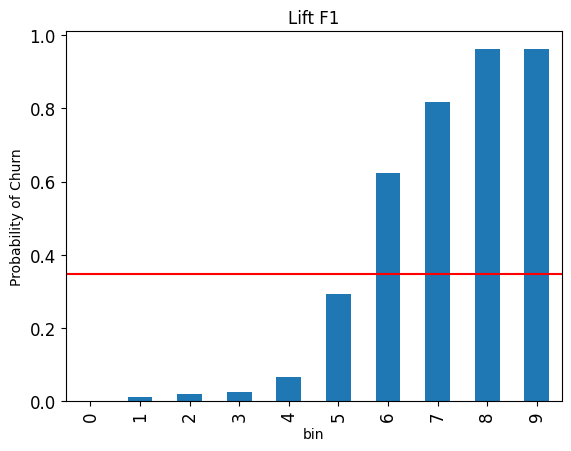

bin
0    0.000332
1    0.009900
2    0.018406
3    0.025736
4    0.065769
5    0.292258
6    0.624415
7    0.818373
8    0.961921
9    0.961977
Name: lift_positive, dtype: float64

In [ ]:
f1_bins = lift_f1['lift_positive']

f1_bins.plot.bar()
plt.title('Lift F1')
plt.ylabel('Probability of Churn')

plt.xticks(rotation=90, fontsize=12)

plt.axhline(y = 0.346649, color = 'r', linestyle = '-')

plt.yticks(fontsize=12)

plt.show()

f1_bins